# Check Capse.jl
In this notebook we are going to check the accuracy of our emulators, using `EmulaotrsTrainer.jl` utils.

In [1]:
using Statistics, DataFrames, JSON3, Plots, LinearAlgebra, BenchmarkTools, NPZ, Random, AbstractCosmologicalEmulators, JSON
using Base: @kwdef
#using BSON: @save
#using BSON: @load
#using BSON
using LaTeXStrings
using NPZ
using Capse

In [2]:
using Revise
using EmulatorsTrainer

In [3]:
path_test = "/home/marcobonici/Desktop/test_camb/0Ac65SgVEv/"
json_string_test = read(path_test*"capse_dict.json", String)
cosmo_pars_test = JSON3.read(json_string_test)
CℓTT_test = npzread(path_test*"cl_BB.npy")[3:5001]
#CℓEE_test = npzread(path_test*"clEE.npy")[3:5001]
#CℓTE_test = npzread(path_test*"clTE.npy")[3:5001]
#CℓPP_test = npzread(path_test*"clPP.npy")[3:5001]
ℓ = Array(2:5000);

In [4]:
ll_SO = npzread("noise_SO_ll.npy")
ll_SO = ll_SO[3:4999]
fac = ll_SO .* (ll_SO .+ 1) ./ (2π)
TT_n_SO = npzread("noise_SO_TT.npy")[3:4999] .* fac
EE_n_SO = npzread("noise_SO_EE.npy")[3:4999] .* fac
PP_n_SO = npzread("noise_SO_PP.npy")[3:4999];# ./ fac;

In [5]:
ll_S4 = npzread("noise_S4_ll.npy")[3:4999]
fac = ll_S4 .* (ll_S4 .+ 1) ./ (2π)
fac_kk = (ll_S4 .* (ll_S4 .* 1)).^2 / 4
TT_n_S4 = npzread("noise_S4_TT.npy")[3:4999] .* fac
EE_n_S4 = npzread("noise_S4_EE.npy")[3:4999] .* fac
PP_n_S4 = npzread("noise_S4_PP.npy")[3:4999];# .* fac;

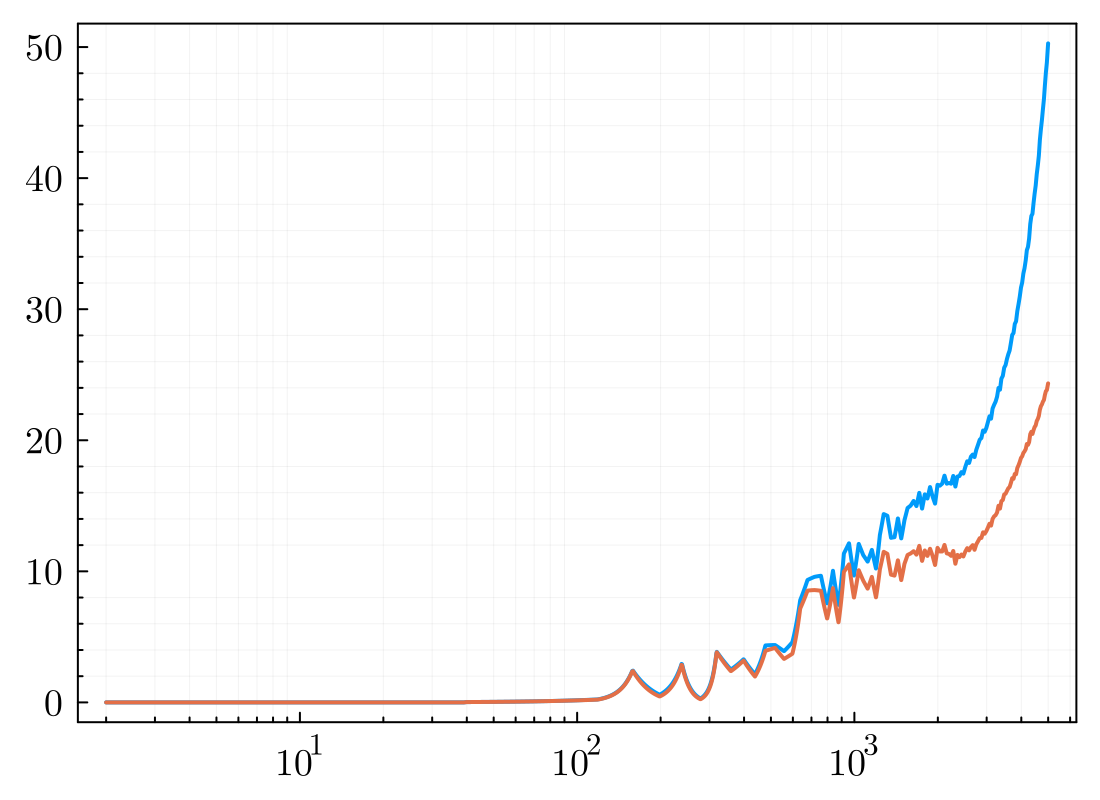

In [6]:
plot_font = "Computer Modern"

Plots.default(titlefont = (16, plot_font), fontfamily=plot_font,
        linewidth=2, framestyle=:box, fg_legend =:black, label=nothing, grid=false, tickfontsize=12, size = (550, 400), labelfontsize = 13, dpi = 200, minorgrid = true, xticks = [1,10,100, 1000], xscale=:log10)

plt = plot(ll_SO, TT_n_SO)
plot!(plt, ll_S4, TT_n_S4)

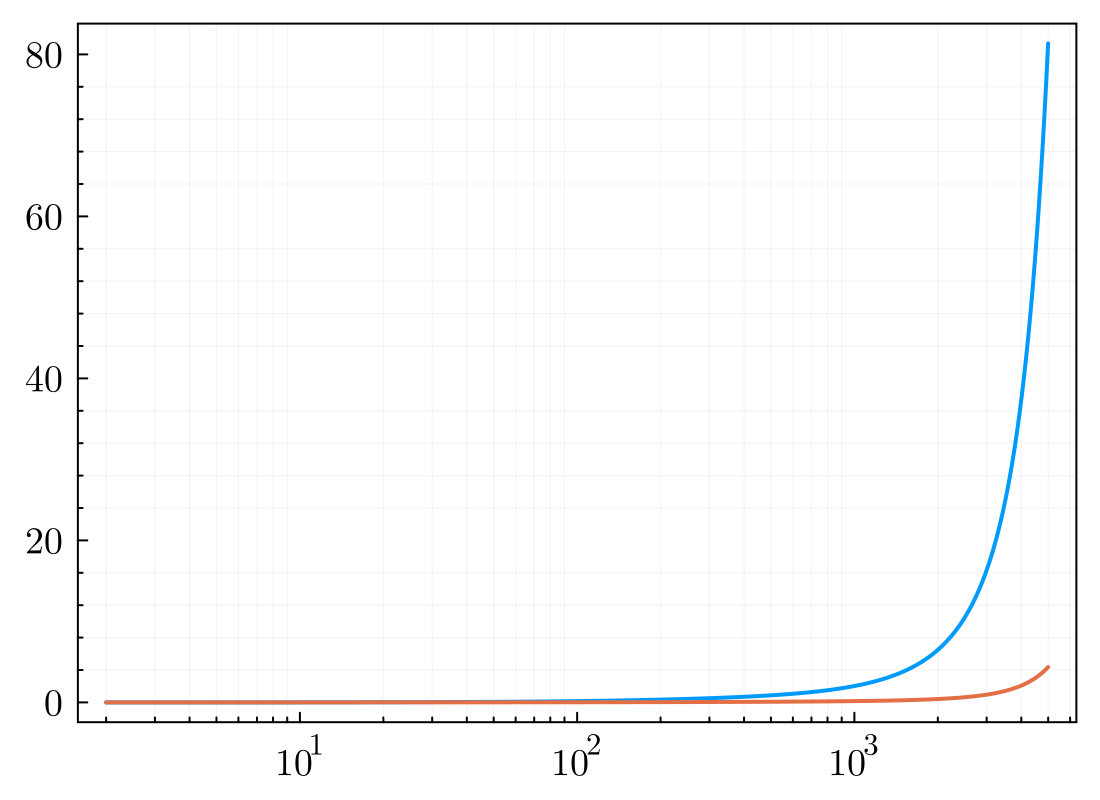

In [7]:
plot_font = "Computer Modern"

Plots.default(titlefont = (16, plot_font), fontfamily=plot_font,
        linewidth=2, framestyle=:box, fg_legend =:black, label=nothing, grid=false, tickfontsize=12, size = (550, 400), labelfontsize = 13, dpi = 200, minorgrid = true, xticks = [1,10,100, 1000], xscale=:log10)

plt = plot(ll_SO, EE_n_SO)
plot!(plt, ll_S4, EE_n_S4)

In [8]:
input_test = [cosmo_pars_test["ln10As"], cosmo_pars_test["ns"], cosmo_pars_test["H0"], cosmo_pars_test["ombh2"], cosmo_pars_test["omch2"], cosmo_pars_test["tau"]]

6-element Vector{Float64}:
  3.388625
  0.9856337500000001
 90.8125
  0.22450750000000003
  0.087005
  0.0823625

In [9]:
NN_dict = JSON.parsefile("nn_setup.json")
mlpd = AbstractCosmologicalEmulators._get_nn_simplechains(NN_dict);

# $C^{TT}(\ell)$ emulator test

In [10]:
weights_TT = npzread("weights_BB_lcdm.npy")
trained_emu_TT = Capse.SimpleChainsEmulator(Architecture= mlpd, Weights = weights_TT)
CℓTT_emu = Capse.CℓEmulator(TrainedEmulator = trained_emu_TT, ℓgrid = ℓ,
                             InMinMax = npzread("inMinMax_lcdm.npy"),
                             OutMinMax = npzread("outMinMaxCℓBB_lcdm.npy"));

In [11]:
CℓTT_capse = Capse.get_Cℓ(input_test, CℓTT_emu);

In [12]:
@benchmark Capse.get_Cℓ($input_test, $CℓTT_emu)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  30.870 μs …  1.554 ms  ┊ GC (min … max): 0.00% … 92.97%
 Time  (median):     35.416 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   38.562 μs ± 50.970 μs  ┊ GC (mean ± σ):  4.75% ±  3.53%

        ▄▇██▇▆▅▄▃▃▂▁▁                                         ▂
  ▅▇▆▇███████████████████▇▆▅▅▅▆▅▄▅▅▆▅▆▆▇▆▅▇▇▇▇▇▆▆▆▆▄▅▆▄▄▅▄▅▅▆ █
  30.9 μs      Histogram: log(frequency) by time      59.6 μs <

 Memory estimate: 78.77 KiB, allocs estimate: 11.

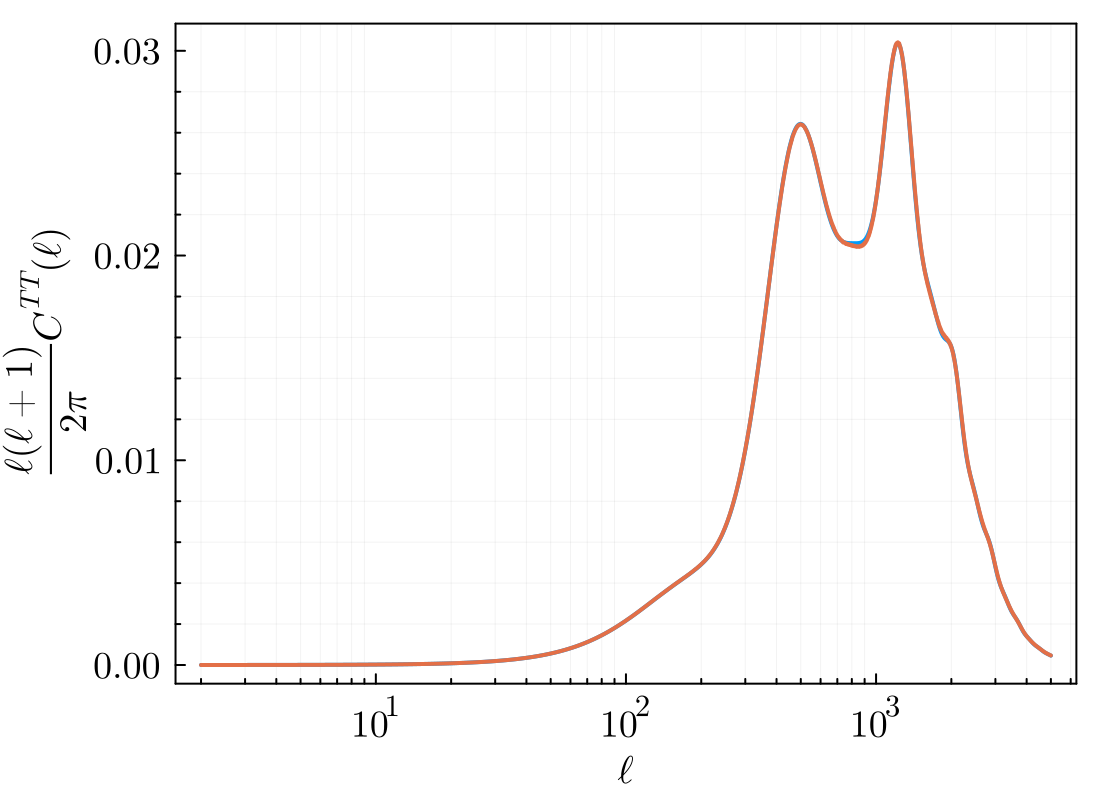

In [13]:

plt = Plots.plot(xlabel=L"ℓ", ylabel=L"\frac{\ell(\ell+1)}{2\pi}C^{TT}(\ell)",legend=:bottomright)
Plots.plot!(plt, ℓ, CℓTT_test)
Plots.plot!(plt, ℓ, CℓTT_capse)# .* ℓ .*(ℓ .+1))
plt

$$
\sigma_{\ell, \mathrm{CMB}}^{\{\mathrm{TT}, \mathrm{EE}\}}=\sqrt{\frac{2}{f_{\mathrm{sky}}(2 \ell+1)}}\left(C_{\ell, \text { true }}^{\{\mathrm{TT}, \mathrm{EE}\}}+N_{\ell}^{\{\mathrm{TT}, \mathrm{EE}, \phi \phi\}}\right)
$$
with $f_\mathrm{sky} = 1$ and $N_\ell=0$

In [14]:
function compute_σXX(CℓXX, ℓ)
    result = Float64.(similar(ℓ))
    for i in 1:length(ℓ)
        result[i] = sqrt(2/( (2. *ℓ[i]+1.))) * (CℓXX[i])
    end
    return result
end

function compute_σXX(CℓXX, ℓ, NXX, f_sky)
    result = Float64.(similar(ℓ))
    for i in 1:length(ℓ)
        result[i] = sqrt(2/(f_sky .* (2. *ℓ[i]+1.))) * (CℓXX[i] + NXX[i])
    end
    return result
end

compute_σXX (generic function with 2 methods)

In [15]:
σTT = compute_σXX(CℓTT_test, ℓ);
σTT_n = compute_σXX(CℓTT_test[1:4997], ℓ[1:4997], EE_n_SO, 1. );

## Deep test

In [16]:
Cℓ_directory = "/home/marcobonici/Desktop/test_camb/"

"/home/marcobonici/Desktop/test_camb/"

In [17]:
pars_array = ["ln10As", "ns", "H0", "ombh2", "omch2", "tau"]
Cℓ_directory = "/home/marcobonici/Desktop/test_camb/"

get_ground_truth(location) = npzread(location*"/cl_BB.npy")[3:4999]
get_emu_prediction(input_test) = Capse.get_Cℓ(input_test, CℓTT_emu)[1:4997]
ℓ = Array(2:4998)

function compute_σXX(location::String, obs_file::String, ℓ::Array, NXX::Array, f_sky::Real)
    CℓXX = npzread(location*"/"*obs_file)[3:5001]
    result = Float64.(similar(ℓ))
    for i in 1:length(ℓ)
        result[i] = sqrt(2/(f_sky .* (2. *ℓ[i]+1.))) * (CℓXX[i] + NXX[i])
    end
    return result
end

get_σ_CV(location) = compute_σXX(location, "cl_BB.npy", ℓ, zeros(length(ℓ)), 1.)
get_σ_SO(location) = compute_σXX(location, "cl_BB.npy", ℓ, EE_n_SO, 0.4)
get_σ_S4(location) = compute_σXX(location, "cl_BB.npy", ℓ, EE_n_S4, 0.4)

test_CV = EmulatorsTrainer.evaluate_sorted_residuals(Cℓ_directory, "capse_dict.json", pars_array,
    get_ground_truth, get_emu_prediction, get_σ_CV, 2746, 4997)
test_SO = EmulatorsTrainer.evaluate_sorted_residuals(Cℓ_directory, "capse_dict.json", pars_array,
    get_ground_truth, get_emu_prediction, get_σ_SO, 2746, 4997)
test_S4 = EmulatorsTrainer.evaluate_sorted_residuals(Cℓ_directory, "capse_dict.json", pars_array,
    get_ground_truth, get_emu_prediction, get_σ_S4, 2746, 4997)

3×4997 Matrix{Float64}:
 0.00289338  0.00329649  0.00380187  0.00396487  …  7.94188e-5   7.70096e-5
 0.00723083  0.00838162  0.00918865  0.0101354      0.000253048  0.000258915
 0.0128081   0.0139186   0.0152281   0.0182015      0.000484535  0.000484411

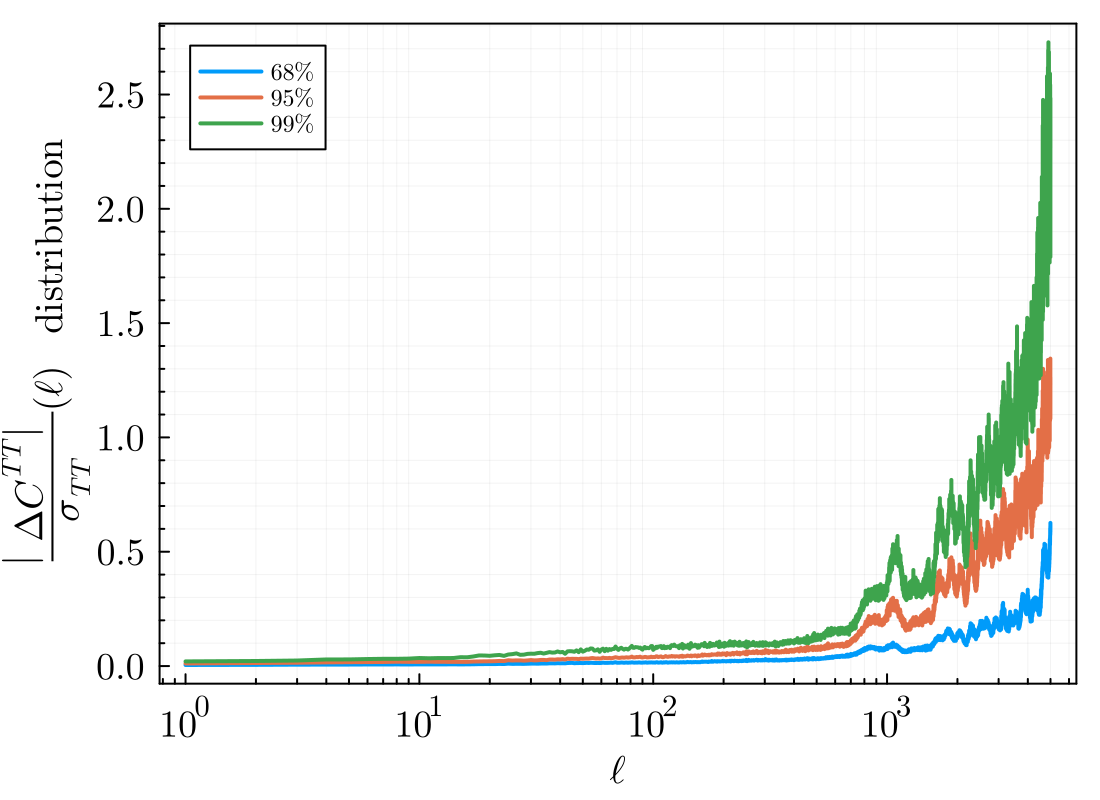

In [18]:
plt = Plots.plot(test_CV[1,:], xlabel=L"ℓ", ylabel=L"\frac{\left|\Delta C^{TT}\right|}{\sigma_{{TT}}}(\ell)\quad \mathrm{distribution}",legend=:topleft, label = L"68\%")
Plots.plot!(plt, test_CV[2,:], label = L"95\%")
Plots.plot!(plt, test_CV[3,:], label = L"99\%")
savefig("error_distribution_TT_CV.png")
savefig("error_distribution_TT_CV.pdf")
plt

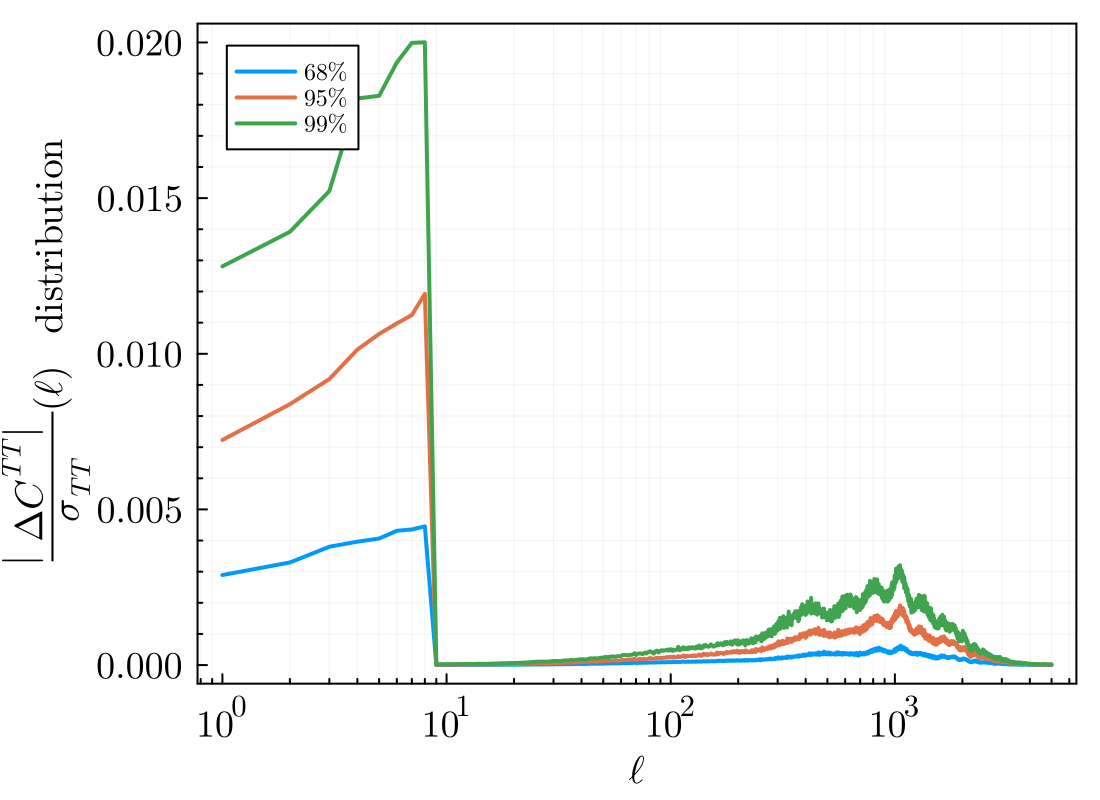

In [19]:
plt = Plots.plot(test_SO[1,:], xlabel=L"ℓ", ylabel=L"\frac{\left|\Delta C^{TT}\right|}{\sigma_{{TT}}}(\ell)\quad \mathrm{distribution}",legend=:topleft, label = L"68\%")
Plots.plot!(plt, test_SO[2,:], label = L"95\%")
Plots.plot!(plt, test_SO[3,:], label = L"99\%")
savefig("error_distribution_TT_SO.png")
savefig("error_distribution_TT_SO.pdf")
plt

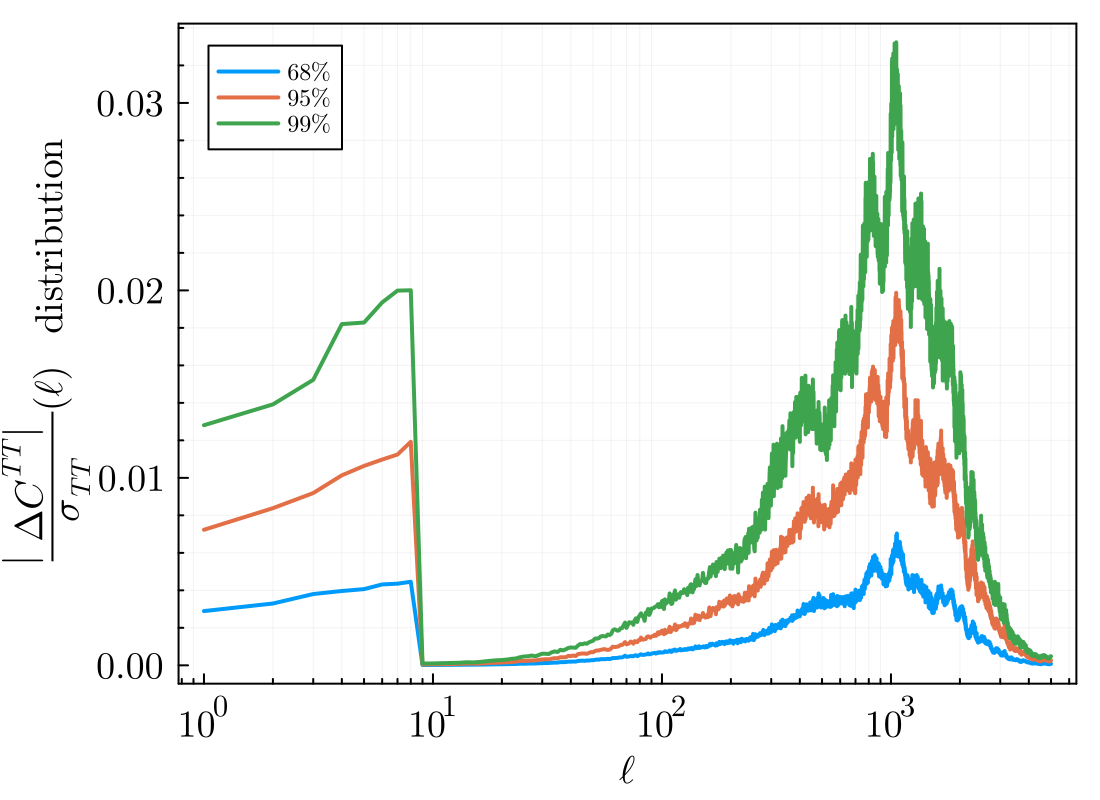

In [20]:
plt = Plots.plot(test_S4[1,:], xlabel=L"ℓ", ylabel=L"\frac{\left|\Delta C^{TT}\right|}{\sigma_{{TT}}}(\ell)\quad \mathrm{distribution}",legend=:topleft, label = L"68\%")
Plots.plot!(plt, test_S4[2,:], label = L"95\%")
Plots.plot!(plt, test_S4[3,:], label = L"99\%")
savefig("error_distribution_TT_S4.png")
savefig("error_distribution_TT_S4.pdf")
plt

# $C^{EE}(\ell)$ emulator test

In [ ]:
weights_EE = npzread("weights_EE_lcdm.npy")
trained_emu_EE = Capse.SimpleChainsEmulator(Architecture= mlpd, Weights = weights_EE)
CℓEE_emu = Capse.CℓEmulator(TrainedEmulator = trained_emu_EE, ℓgrid = ℓ,
                             InMinMax = npzread("inMinMax_lcdm.npy"),
                             OutMinMax = npzread("outMinMaxCℓEE_lcdm.npy"));

## Quick test

In [ ]:
CℓEE_capse = Capse.get_Cℓ(input_test, CℓEE_emu);

In [ ]:
plot_font = "Computer Modern"

Plots.default(titlefont = (16, plot_font), fontfamily=plot_font,
        linewidth=2, framestyle=:box, fg_legend =:black, label=nothing, grid=false, tickfontsize=12, size = (550, 400), labelfontsize = 13, dpi = 200)

plt = Plots.plot(xlabel=L"ℓ", ylabel=L"\frac{\ell(\ell+1)}{2\pi}C^{EE}(\ell)",legend=:bottomright)
Plots.plot!(plt, ℓ, CℓEE_test)# .* ℓ .*(ℓ .+1))
Plots.plot!(plt, ℓ, CℓEE_capse)# .* ℓ .*(ℓ .+1))

In [ ]:
σEE = compute_σXX(CℓEE_test, ℓ);

In [ ]:
plt = Plots.plot(xlabel=L"ℓ", ylabel=L"\frac{\left|\Delta C^{EE}\right|}{\sigma_{EE}}(\ell)",legend=:bottomright)
Plots.plot!(plt, ℓ, abs.(CℓEE_test .- CℓEE_capse)./σEE )
savefig("residuals_ClEE.png")
plt

## Deep Test

In [ ]:
#@time residuals_CℓEE = evaluate_residuals_XX(Cℓ_directory, CℓEE_emu, "EE");

In [ ]:
#residuals_CℓEE_n_SO = evaluate_residuals_XX(Cℓ_directory, CℓEE_emu, "EE", EE_n_SO)
#residuals_CℓEE_n_S4 = evaluate_residuals_XX(Cℓ_directory, CℓEE_emu, "EE", EE_n_S4);

In [ ]:
"""
sorted_residuals_CℓEE = zeros(10000, 4999)
for i in 1:4999
    sorted_residuals_CℓEE[:,i] = sort(residuals_CℓEE[:,i])
end

sorted_residuals_CℓEE_n_SO = zeros(10000, 4997)
for i in 1:4997
    sorted_residuals_CℓEE_n_SO[:,i] = sort(residuals_CℓEE_n_SO[:,i])
end

sorted_residuals_CℓEE_n_S4 = zeros(10000, 4997)
for i in 1:4997
    sorted_residuals_CℓEE_n_S4[:,i] = sort(residuals_CℓEE_n_S4[:,i])
end"""

sorted_residuals_EE = evaluate_sorted_residuals_XX(Cℓ_directory, CℓEE_emu, "EE")
sorted_residuals_EE_SO = evaluate_sorted_residuals_XX(Cℓ_directory, CℓEE_emu, "EE", EE_n_SO)
sorted_residuals_EE_S4 = evaluate_sorted_residuals_XX(Cℓ_directory, CℓEE_emu, "EE", EE_n_S4)

In [ ]:
plt = Plots.plot(sorted_residuals_EE[1,:], xlabel=L"ℓ", ylabel=L"\frac{\left|\Delta C^{EE}\right|}{\sigma_{EE}}(\ell)\quad \mathrm{distribution}",legend=:topright, label = L"68\%")
Plots.plot!(plt, sorted_residuals_EE[2,:], label = L"95\%")
Plots.plot!(plt, sorted_residuals_EE[3,:], label = L"99\%")
savefig("error_distribution_EE_CV.png")
savefig("error_distribution_EE_CV.pdf")
plt

In [ ]:
plt = Plots.plot(sorted_residuals_EE[1,:], xlabel=L"ℓ", ylabel=L"\frac{\left|\Delta C^{EE}\right|}{\sigma_{EE}}(\ell)\quad \mathrm{distribution}",legend=:topright, label = L"68\%")
Plots.plot!(plt, sorted_residuals_EE[2,:], label = L"95\%")
Plots.plot!(plt, sorted_residuals_EE[3,:], label = L"99\%", ylimit = [0,1])
savefig("error_distribution_EE_CV_zoom.png")
savefig("error_distribution_EE_CV_zoom.pdf")
plt

In [ ]:
plt = Plots.plot(sorted_residuals_EE_SO[1,:], xlabel=L"ℓ", ylabel=L"\frac{\left|\Delta C^{EE}\right|}{\sigma_{EE}}(\ell)\quad \mathrm{distribution}",legend=:topright, label = L"68\%")
Plots.plot!(plt, sorted_residuals_EE_SO[2,:], label = L"95\%")
Plots.plot!(plt, sorted_residuals_EE_SO[3,:], label = L"99\%", xscale=:log10, ylim = [0,0.10])
savefig("error_distribution_EE_SO.png")
savefig("error_distribution_EE_SO.pdf")
plt

In [ ]:
plt = Plots.plot(sorted_residuals_EE_S4[1,:], xlabel=L"ℓ", ylabel=L"\frac{\left|\Delta C^{EE}\right|}{\sigma_{EE}}(\ell)\quad \mathrm{distribution}",legend=:topright, label = L"68\%")
Plots.plot!(plt, sorted_residuals_EE_S4[2,:], label = L"95\%")
Plots.plot!(plt, sorted_residuals_EE_S4[3,:], label = L"99\%", xscale=:log10)
savefig("error_distribution_EE.png")
plt

In [ ]:
plt = Plots.plot(sorted_residuals_EE_S4[1,:], xlabel=L"ℓ", ylabel=L"\frac{\left|\Delta C^{EE}\right|}{\sigma_{EE}}(\ell)\quad \mathrm{distribution}",legend=:topright, label = L"68\%")
Plots.plot!(plt, sorted_residuals_EE_S4[2,:], label = L"95\%")
Plots.plot!(plt, sorted_residuals_EE_S4[3,:], label = L"99\%", ylim=[0,0.1])
savefig("error_distribution_EE_S4.png")
savefig("error_distribution_EE_S4.pdf")
plt

# $C^{TE}(\ell)$ emulator test

In [ ]:
weights_TE = npzread("weights_TE_lcdm.npy")
trained_emu_TE = Capse.SimpleChainsEmulator(Architecture= mlpd, Weights = weights_TE)
CℓTE_emu = Capse.CℓEmulator(TrainedEmulator = trained_emu_TE, ℓgrid = ℓ,
                             InMinMax = npzread("inMinMax_lcdm.npy"),
                             OutMinMax = npzread("outMinMaxCℓTE_lcdm.npy"));

In [ ]:
function compute_σTE(CℓTT, CℓEE, CℓTE, ℓ)
    result = Float64.(similar(ℓ))
    for i in 1:length(ℓ)
        result[i] = sqrt((CℓTT[i]*CℓEE[i]+(CℓTE[i])^2)/(2. *ℓ[i]+1.))
    end
    return result
end

function compute_σTE(CℓTT, CℓEE, CℓTE, NTT, NEE, ℓ, f_sky)
    result = Float64.(similar(ℓ))
    CℓTT .+= NTT
    CℓEE .+= NEE
    for i in 1:length(ℓ)
        result[i] = sqrt((CℓTT[i]*CℓEE[i]+(CℓTE[i])^2)/ (f_sky .* (2. *ℓ[i]+1.)))
    end
    return result
end

$$
\sigma_{\ell, \mathrm{CMB}}^{\mathrm{TE}} =\sqrt{\frac{1}{f_{\mathrm{sky}}(2 \ell+1)}} \times \sqrt{C_{\ell, \text { true }}^{\mathrm{TE}} C_{\ell, \text { true }}^{\mathrm{TE}}+\left(C_{\ell, \text { true }}^{\mathrm{TT}}+N_{\ell}^{\mathrm{TT}}\right)\left(C_{\ell, \text { true }}^{\mathrm{EE}}+N_{\ell}^{\mathrm{EE}}\right)},
$$
with $f_\mathrm{sky}=1$.

In [ ]:
CℓTE_capse = Capse.get_Cℓ(input_test, CℓTE_emu);

In [ ]:
plot_font = "Computer Modern"

Plots.default(titlefont = (16, plot_font), fontfamily=plot_font,
        linewidth=2, framestyle=:box, fg_legend =:black, label=nothing, grid=false, tickfontsize=12, size = (550, 400), labelfontsize = 13, dpi = 200)

plt = Plots.plot(xlabel=L"ℓ", ylabel=L"\frac{\ell(\ell+1)}{2\pi}C^{TE}(\ell)",legend=:bottomright)
Plots.plot!(plt, ℓ, CℓTE_test)# .* ℓ .*(ℓ .+1))
Plots.plot!(plt, ℓ, CℓTE_capse)# .* ℓ .*(ℓ .+1))

In [ ]:
σTE = compute_σTE(CℓTT_test, CℓEE_test, CℓTE_test, ℓ)
#σTE_n = compute_σTE(CℓTT_test[1:4997], CℓEE_test[1:4997], CℓTE_test[1:4997], TT_n_SO, EE_n_SO, ℓ[1:4997], 1.);

In [ ]:
plt = Plots.plot(xlabel=L"ℓ", ylabel=L"\frac{\left|\Delta C^{TE}\right|}{\sigma_{{TE}}}(\ell)",legend=:bottomright)
Plots.plot!(plt, ℓ, abs.(CℓTE_test .- CℓTE_capse)./σTE )
savefig("residuals_ClTE.png")
plt

## Deep Test

In [ ]:
function evaluate_residuals_TE(Directory,  CℓTE_emu)
    my_values = zeros(20000, 4999)
    i = 0
    for (root, dirs, files) in walkdir(Directory)
        for file in files
            file_extension = file[findlast(isequal('.'),file):end]
            if file_extension == ".json"
                res = read_Cℓ_compute_res_TE(root, CℓTE_emu)
                i += 1
                my_values[i, :] = res
            end
        end
    end
    return my_values
end


function read_Cℓ_compute_res_TE(location, CℓTE_emu)
    json_string = read(location*"/cosmology_capse.json", String)
    cosmo_pars_test = JSON3.read(json_string)
    
    input_test = [cosmo_pars_test["ln10As"],
        cosmo_pars_test["ns"],
        cosmo_pars_test["H0"],
        cosmo_pars_test["ombh2"],
        cosmo_pars_test["omch2"],
        cosmo_pars_test["tau"]]
    
    CℓTT_test = npzread(location*"/clTT.npy")[3:5001]
    CℓEE_test = npzread(location*"/clEE.npy")[3:5001]
    CℓTE_test = npzread(location*"/clTE.npy")[3:5001]
    
    ℓ = npzread(location*"/ll.npy")[3:5001]
    
    CℓTE_capse = Capse.get_Cℓ(input_test, CℓTE_emu)
    σTE = compute_σTE(CℓTT_test, CℓEE_test, CℓTE_test, ℓ)
    
    res = abs.(CℓTE_test .- CℓTE_capse)./σTE
        
    return res
end

function evaluate_residuals_TE(Directory,  CℓTE_emu, NTT, NEE, f_sky)
    my_values = zeros(20000, 4997)
    i = 0
    for (root, dirs, files) in walkdir(Directory)
        for file in files
            file_extension = file[findlast(isequal('.'),file):end]
            if file_extension == ".json"
                res = read_Cℓ_compute_res_TE(root, CℓTE_emu, NTT, NEE, f_sky)
                i += 1
                my_values[i, :] = res
            end
        end
    end
    return my_values
end


function read_Cℓ_compute_res_TE(location, CℓTE_emu, NTT, NEE, f_sky)
    json_string = read(location*"/cosmology_capse.json", String)
    cosmo_pars_test = JSON3.read(json_string)
    
    input_test = [cosmo_pars_test["ln10As"],
        cosmo_pars_test["ns"],
        cosmo_pars_test["H0"],
        cosmo_pars_test["ombh2"],
        cosmo_pars_test["omch2"],
        cosmo_pars_test["tau"]]
    
    CℓTT_test = npzread(location*"/clTT.npy")[3:4999]
    CℓEE_test = npzread(location*"/clEE.npy")[3:4999]
    CℓTE_test = npzread(location*"/clTE.npy")[3:4999]
    
    ℓ = npzread(location*"/ll.npy")[3:4999]
    
    CℓTE_capse = Capse.get_Cℓ(input_test, CℓTE_emu)[1:4997]
    σTE = compute_σTE(CℓTT_test, CℓEE_test, CℓTE_test, NTT, NEE, ℓ, f_sky)
    
    res = abs.(CℓTE_test .- CℓTE_capse)./σTE
        
    return res
end

function evaluate_sorted_residuals_TE(Directory, CℓXX_emu, N_TT, N_EE, f_sky)
    residuals = evaluate_residuals_TE(Directory, CℓXX_emu, N_TT, N_EE, f_sky)
    n_elements, n_output = size(residuals)
    return sort_residuals(residuals, n_output, n_elements)
end

function evaluate_sorted_residuals_TE(Directory, CℓXX_emu)
    residuals = evaluate_residuals_TE(Directory, CℓXX_emu)
    n_elements, n_output = size(residuals)
    return sort_residuals(residuals, n_output, n_elements)
end

In [ ]:
TT_n_S4

In [ ]:
sorted_residuals_TE = evaluate_sorted_residuals_TE(Cℓ_directory, CℓTE_emu)
sorted_residuals_TE_SO = evaluate_sorted_residuals_TE(Cℓ_directory, CℓTE_emu, TT_n_SO, EE_n_SO, 0.4)
sorted_residuals_TE_S4 = evaluate_sorted_residuals_TE(Cℓ_directory, CℓTE_emu, TT_n_S4, EE_n_S4, 0.4)

In [ ]:
#@time residuals_CℓTE = evaluate_residuals_TE(Cℓ_directory, CℓTE_emu);

In [ ]:
#residuals_CℓTE_n_SO = evaluate_residuals_TE(Cℓ_directory, CℓTE_emu, TT_n_SO, EE_n_SO, 0.4)
#residuals_CℓTE_n_S4 = evaluate_residuals_TE(Cℓ_directory, CℓTE_emu, TT_n_S4, EE_n_S4, 0.4);

In [ ]:
"""
sorted_residuals_CℓTE = zeros(10000, 4999)
for i in 1:4999
    sorted_residuals_CℓTE[:,i] = sort(residuals_CℓTE[:,i])
end

sorted_residuals_CℓTE_n_SO = zeros(10000, 4997)
for i in 1:4997
    sorted_residuals_CℓTE_n_SO[:,i] = sort(residuals_CℓTE_n_SO[:,i])
end

sorted_residuals_CℓTE_n_S4 = zeros(10000, 4997)
for i in 1:4997
    sorted_residuals_CℓTE_n_S4[:,i] = sort(residuals_CℓTE_n_S4[:,i])
end
"""

In [ ]:
plt = Plots.plot(sorted_residuals_TE[1,:],xlabel=L"ℓ", ylabel=L"\frac{\left|\Delta C^{TE}\right|}{\sigma_{{TE}}}(\ell)\quad \mathrm{distribution}",legend=:topright, label = L"68\%")
Plots.plot!(plt, sorted_residuals_TE[2,:], label = L"95\%")
Plots.plot!(plt, sorted_residuals_TE[3,:], label = L"99\%")
savefig("error_distribution_TE_CV.png")
savefig("error_distribution_TE_CV.pdf")
plt

In [ ]:
plt = Plots.plot(sorted_residuals_TE_SO[1,:],xlabel=L"ℓ", ylabel=L"\frac{\left|\Delta C^{TE}\right|}{\sigma_{{TE}}}(\ell)\quad \mathrm{distribution}",legend=:topright, label = L"68\%")
Plots.plot!(plt, sorted_residuals_TE_SO[2,:], label = L"95\%")
Plots.plot!(plt, sorted_residuals_TE_SO[3,:], label = L"99\%", xscale=:log10)
savefig("error_distribution_TE_SO.png")
savefig("error_distribution_TE_SO.pdf")
plt

In [ ]:
plt = Plots.plot(sorted_residuals_TE_S4[1,:],xlabel=L"ℓ", ylabel=L"\frac{\left|\Delta C^{TE}\right|}{\sigma_{{TE}}}(\ell)\quad \mathrm{distribution}",legend=:topright, label = L"68\%")
Plots.plot!(plt, sorted_residuals_TE_S4[2,:], label = L"95\%")
Plots.plot!(plt, sorted_residuals_TE_S4[3,:], label = L"99\%", xscale=:log10)
savefig("error_distribution_TE_S4.png")
savefig("error_distribution_TE_S4.pdf")
plt

# $C^{\phi\phi}(\ell)$ emulator test

In [ ]:
weights_PP = npzread("weights_PP_lcdm.npy")
trained_emu_PP = Capse.SimpleChainsEmulator(Architecture= mlpd, Weights = weights_PP)
CℓPP_emu = Capse.CℓEmulator(TrainedEmulator = trained_emu_PP, ℓgrid = ℓ,
                             InMinMax = npzread("inMinMax_lcdm.npy"),
                             OutMinMax = npzread("outMinMaxCℓPP_lcdm.npy"));

In [ ]:
CℓPP_capse = Capse.get_Cℓ(input_test, CℓPP_emu);

In [ ]:
plot_font = "Computer Modern"

Plots.default(titlefont = (16, plot_font), fontfamily=plot_font,
        linewidth=2, framestyle=:box, fg_legend =:black, label=nothing, grid=false, tickfontsize=12, size = (550, 400), labelfontsize = 13, dpi = 200)

plt = Plots.plot(xlabel=L"ℓ", ylabel=L"\frac{(\ell(\ell+1))^2}{2\pi}C^{PP}(\ell)",legend=:bottomright)
Plots.plot!(plt, ℓ, CℓPP_test)# .* (ℓ .*(ℓ .+1)).^2)
Plots.plot!(plt, ℓ, CℓPP_capse)# .* (ℓ .*(ℓ .+1)).^2)

In [ ]:
σPP = compute_σXX(CℓPP_test, ℓ);

In [ ]:
plt = Plots.plot(xlabel=L"ℓ", ylabel=L"\frac{\left|\Delta C^{PP}\right|}{\sigma_{C^{PP}}}(\ell)",legend=:bottomright)
Plots.plot!(plt, ℓ, abs.(CℓPP_test .- CℓPP_capse)./σPP )
savefig("residuals_ClPP.png")
plt

## Deep Test

In [ ]:
sorted_residuals_PP = evaluate_sorted_residuals_XX(Cℓ_directory, CℓPP_emu, "PP")
sorted_residuals_PP_SO = evaluate_sorted_residuals_XX(Cℓ_directory, CℓPP_emu, "PP", PP_n_SO)
sorted_residuals_PP_S4 = evaluate_sorted_residuals_XX(Cℓ_directory, CℓPP_emu, "PP", PP_n_S4)

In [ ]:
#@time residuals_CℓPP = evaluate_residuals_XX(Cℓ_directory, CℓPP_emu, "PP");

In [ ]:
#residuals_CℓPP_n_SO = evaluate_residuals_XX(Cℓ_directory, CℓPP_emu, "PP", PP_n_SO)
#residuals_CℓPP_n_S4 = evaluate_residuals_XX(Cℓ_directory, CℓPP_emu, "PP", PP_n_S4);

In [ ]:
"""
sorted_residuals_CℓPP = zeros(10000, 4999)
for i in 1:4999
    sorted_residuals_CℓPP[:,i] = sort(residuals_CℓPP[:,i])
end

sorted_residuals_CℓPP_n_SO = zeros(10000, 4997)
for i in 1:4997
    sorted_residuals_CℓPP_n_SO[:,i] = sort(residuals_CℓPP_n_SO[:,i])
end

sorted_residuals_CℓPP_n_S4 = zeros(10000, 4997)
for i in 1:4997
    sorted_residuals_CℓPP_n_S4[:,i] = sort(residuals_CℓPP_n_S4[:,i])
end
"""

In [ ]:
plt = Plots.plot(sorted_residuals_PP[1,:], xlabel=L"ℓ", ylabel=L"\frac{\left|\Delta C^{PP}\right|}{\sigma_{PP}}(\ell)\quad \mathrm{distribution}",legend=:topright, label = L"68\%")
Plots.plot!(plt, sorted_residuals_PP[2,:], label = L"95\%")
Plots.plot!(plt, sorted_residuals_PP[3,:], label = L"99\%", xscale=:log10)
savefig("error_distribution_PP_CV.png")
savefig("error_distribution_PP_CV.pdf")
plt

In [ ]:
plt = Plots.plot(sorted_residuals_PP_SO[1,:], xlabel=L"ℓ", ylabel=L"\frac{\left|\Delta C^{PP}\right|}{\sigma_{PP}}(\ell)\quad \mathrm{distribution}",legend=:topright, label = L"68\%")
Plots.plot!(plt, sorted_residuals_PP_SO[2,:], label = L"95\%")
Plots.plot!(plt, sorted_residuals_PP_SO[3,:], label = L"99\%", xscale=:log10)
savefig("error_distribution_PP_SO.png")
savefig("error_distribution_PP_SO.pdf")
plt

In [ ]:
plt = Plots.plot(sorted_residuals_PP_S4[1,:], xlabel=L"ℓ", ylabel=L"\frac{\left|\Delta C^{PP}\right|}{\sigma_{PP}}(\ell)\quad \mathrm{distribution}",legend=:topright, label = L"68\%")
Plots.plot!(plt, sorted_residuals_PP_S4[2,:], label = L"95\%")
Plots.plot!(plt, sorted_residuals_PP_S4[3,:], label = L"99\%", xscale=:log10)
savefig("error_distribution_PP_S4.png")
savefig("error_distribution_PP_S4.pdf")
plt